In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from MARBLE import plotting, geometry, utils, net
from DE_library import simulate_ODE
import pyEDM as pyEDM
from teaspoon.parameter_selection.FNN_n import FNN_n
import matplotlib.pyplot as plt
import example_utils

# Simulate Lorenz system

In [5]:
par = {'sigma': 10.0, 'beta': 8/3.0, 'rho': 28.0, 'tau': 1.0}
fun = 'lorenz'

# par['sigma']*((par['sigma']+par['beta']+3)/(par['sigma']-par['beta']-1))

n=1000
T=50

#simulate system
x0 = [-8.0, 7.0, 27.0]
T = np.linspace(0, T, n)
mu, sigma = 0, 1 # mean and standard deviation
X, V = simulate_ODE(fun, T, x0, par, noise=False, mu=mu, sigma=sigma)

# Plot state-space

<Axes3DSubplot:>

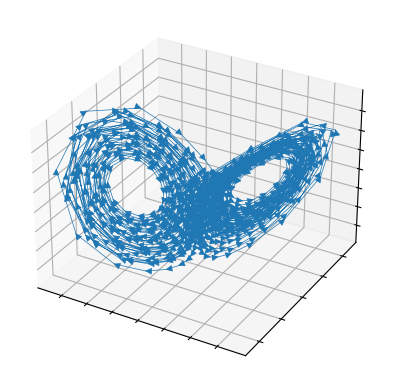

In [10]:
plotting.trajectories(X, V/1e3, style='->', lw=0.5, arrowhead=10, axis=False)

<Axes3DSubplot:>

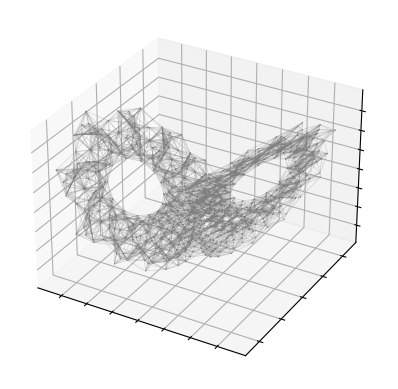

In [17]:
from torch_geometric.utils.convert import to_networkx
data = utils.construct_dataset(X, V, graph_type='cknn', k=20)
G = to_networkx(data, node_attrs=['pos'], edge_attrs=None, to_undirected=True,
        remove_self_loops=True)
plotting.graph(G,labels=None,edge_alpha=0.3, edge_width=0.5)

# Create random projections of state-space to scalar time series

In [28]:
from sklearn import random_projection
transformer = random_projection.SparseRandomProjection(n_components=1)

n_obs = 5

x = []
for i in range(n_obs):
    x_tmp = transformer.fit_transform(X)
    x_tmp = utils.standardise(x_tmp, norm='max')
    x.append(x_tmp)
    
x_stacked = np.hstack(x)
df = utils.to_pandas(x_stacked)

# Plot trajectories

(0.0, 4.0)

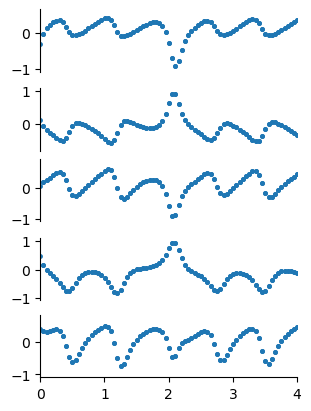

In [29]:
ax = plotting.time_series(T, x, style='.', figsize=(3,4), ms=5)
plt.xlim([0,4])
#plt.savefig('../results/time_series.svg')

# Estimate system dimension

In [30]:
#perc_FNN, E = FNN_n(x_stacked[:,0], 1, maxDim=10, plotting=True, Rtol=15, Atol=2, threshold=10)
E = 3

# Find best multi-view embeddings

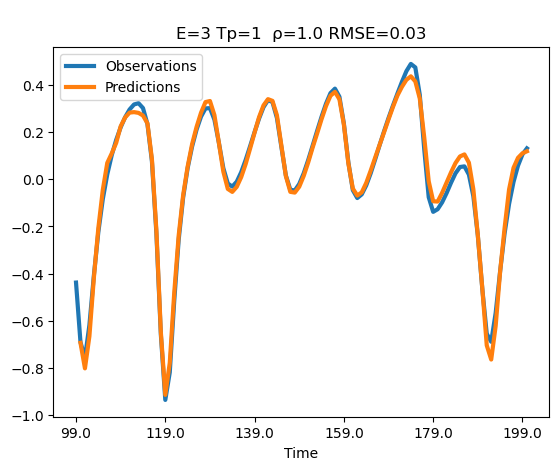

/tmp/ipykernel_1586016/910021037.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  views = np.array(views, dtype=np.int)


In [31]:
#find best embedding views
columns = list(df.columns)[1:]
MVE = pyEDM.Multiview(dataFrame = df, 
                      lib = [1, 100], 
                      pred = [100, 200], 
                      E = E, 
                      D = E,
                      columns = columns, 
                      target = columns[0], 
                      showPlot = True)

views = MVE['View'].iloc[:,:E]
views = np.array(views, dtype=np.int)

#create embeddings
embedding = pyEDM.Embed(dataFrame = df, E = E, tau = -1, columns = columns)
embedding = np.array(embedding.dropna())
all_embeddings = np.stack([embedding[:,v-1] for v in views], axis=2)

# Plot embeddings

Computing neighbours...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1788.66it/s]


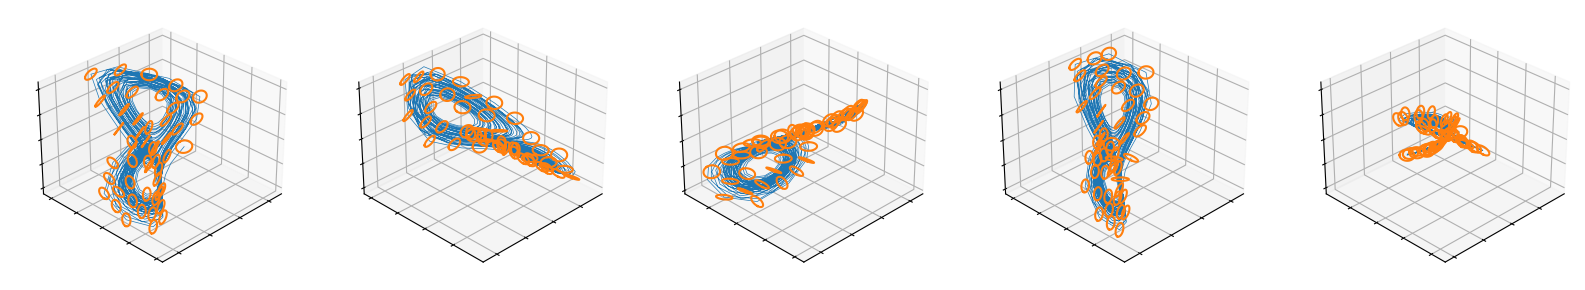

In [32]:
n_emb = 5
N=50

fig = plt.figure(figsize=(20,10))
for j in range(n_emb):
    ax = fig.add_subplot(1, n_emb, j+1, projection='3d')
    ax.view_init(elev=30, azim=45)
    X_emb = all_embeddings[...,j]

    ind, lamb = geometry.furthest_point_sampling(X_emb, N)

    ax = plotting.trajectories(X_emb, ax=ax, style='-', lw=0.5, arrowhead=.05, axis=False)

    ind = np.array(list(set(ind)))
    _, nn = example_utils.find_nn(ind, X_emb, nn=2)

    for i, nn_ in enumerate(nn):
        ax = example_utils.circle(ax, .1, X_emb[[ind[i]] + list(nn_)])
    
#plt.savefig('../results/Takens_views.svg')

# Create dataset

In [60]:
#first create data with the best embedding to fit the graph
best_embedding = all_embeddings[...,0]
feature = np.diff(best_embedding, axis=0) #velocity vectors
pos = best_embedding[:-1]
data = utils.construct_dataset(pos, feature, graph_type='cknn', k=10)

#now add all other embeddings
n_emb = all_embeddings.shape[2]
feature = [np.diff(all_embeddings[...,i], axis=0) for i in range(n_emb)]

#bring it to form [feature_1(x_1),...,feature_n(x_1),  feature_1(x_2),...,feature_n(x_2)]
feature = np.stack(feature, axis=2)
feature = feature.reshape(feature.shape[0], -1)

data.x = utils.np2torch(feature)
data.num_node_features = feature.shape[1]

In [62]:
par = {'batch_size': 256, #batch size, this should be as large as possible
       'epochs': 30, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': True,
       'vector' : True
      }

model = net(data, **par)
model.run_training(data)

Computing gauges...:   0%|                                                                                                             | 0/1 [00:07<?, ?it/s]Process ForkPoolWorker-589:
Process ForkPoolWorker-614:
Process ForkPoolWorker-597:
Process ForkPoolWorker-610:
Process ForkPoolWorker-591:
Process ForkPoolWorker-605:
Process ForkPoolWorker-613:
Process ForkPoolWorker-607:
Process ForkPoolWorker-622:
Process ForkPoolWorker-592:
Process ForkPoolWorker-621:
Process ForkPoolWorker-600:
Process ForkPoolWorker-599:
Process ForkPoolWorker-626:
Process ForkPoolWorker-604:
Process ForkPoolWorker-617:
Process ForkPoolWorker-608:
Process ForkPoolWorker-618:
Process ForkPoolWorker-601:
Process ForkPoolWorker-620:
Process ForkPoolWorker-582:
Process ForkPoolWorker-612:
Process ForkPoolWorker-586:
Process ForkPoolWorker-606:
Process ForkPoolWorker-623:
Process ForkPoolWorker-598:
Process ForkPoolWorker-580:
Process ForkPoolWorker-581:
Process ForkPoolWorker-625:



KeyboardInterrupt: 

Process ForkPoolWorker-611:
Process ForkPoolWorker-579:
Process ForkPoolWorker-624:
Process ForkPoolWorker-603:
Process ForkPoolWorker-602:
Process ForkPoolWorker-587:
Process ForkPoolWorker-615:
Process ForkPoolWorker-619:
Process ForkPoolWorker-588:
Process ForkPoolWorker-590:
Process ForkPoolWorker-609:
Traceback (most recent call last):
Process ForkPoolWorker-596:
Process ForkPoolWorker-584:
Process ForkPoolWorker-594:
Process ForkPoolWorker-593:
Process ForkPoolWorker-583:
Traceback (most recent call last):
Process ForkPoolWorker-595:
Process ForkPoolWorker-585:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceb

  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiproc

  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self

  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/mnt/scratch

  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/m